# Berlin Airbnb Exploratory Data Analysis

In [140]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pathlib import Path
import re
from collections import Counter

import geopandas as gpd

In [141]:
sns.set(style='whitegrid', palette='coolwarm')

## Project Brief

For this project we are interested in predicting the price a airbnb host in Berlin should advertise a new property for. We have 6 different tables that have been scraped from airbnb and provided on kaggle in csv files. The 6 tables are:

- Calendar Summary
- Listings Summary
- Listings Detailed
- Neighbourhoods
- Reviews
- Reviews Detailed

As we are interested in predicting the price a new host should advertise their house for, the reviews data will most likely not be useful as this is retrospective data.

Firstly, I will explore the data sets and make notes of the data format and evaluate the usefulness with predicting the target variable price.

In [142]:
# Read in the data
DATA_PATH = Path("../data/raw/")
calendar = pd.read_csv(DATA_PATH/"calendar.csv")
neighbourhoods = pd.read_csv(DATA_PATH/"neighbourhoods.csv")
reviews = pd.read_csv(DATA_PATH/"reviews.csv")
reviews_summary = pd.read_csv(DATA_PATH/"reviews_summary.csv")
listings = pd.read_csv(DATA_PATH/"listings.csv")
listing_summary = pd.read_csv(DATA_PATH/"listings_summary.csv")

## Calendar

First we will look at the calendar data.

In [143]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8231480 entries, 0 to 8231479
Data columns (total 4 columns):
listing_id    int64
date          object
available     object
price         object
dtypes: int64(1), object(3)
memory usage: 251.2+ MB


In [144]:
calendar.head()

,listing_id,date,available,price
0,2015,2019-09-10,f,NaN
1,2015,2019-09-09,f,NaN
2,2015,2019-09-08,f,NaN
3,2015,2019-09-07,f,NaN
4,2015,2019-09-06,f,NaN


This looks to be a database of every listing in Berlin and the listings availability and price on every day between two dates. Note that the date and price are objects, to be more useful for analysis we should convert these to datetime objects and numeric data respectively.

In [145]:
calendar['date'] = pd.to_datetime(calendar['date'])

Now we want to change the price to continuous data so we first need to know how it is represented in the dataframe.

In [146]:
calendar['price'][calendar['price'].notnull()].head()

128    $76.00
129    $76.00
130    $76.00
131    $76.00
132    $78.00
Name: price, dtype: object

It looks like our data could be represented as strings with dollars and a '.' to seperate dollars and cents, so we want to remove everything that isn't a digit or '.' (just incase there aren't any other characters) and convert to a float.

In [147]:
def price_to_float(price):
    """
    Removes all charcters not digits or decimal points and converts to float.
    """
    if price is np.nan:
        return np.nan
    return float(re.sub('[^\d.]', '', price))

In [148]:
calendar['Price ($)'] = calendar['price'].apply(price_to_float)

Now we have converted our data to a more useable form, lets have a look for any missing data. 

In [149]:
# Percentage of columns with null values
100 * calendar.isnull().sum()[calendar.isnull().sum() != 0] / len(calendar)

price        78.122513
Price ($)    78.122513
dtype: float64

The only column with any missing data is the price column, where 78% of the data is missing values. This could indicate the property is unavailable.

In [150]:
calendar['available'].value_counts()

f    6430639
t    1800841
Name: available, dtype: int64

The availability gives only a true or false, so we can check if the price is missing if the listing is unavailable.

In [151]:
print(
    "Null values when available column is 'f': " + 
    str(calendar[calendar["available"] == "f"].isnull().sum()['price'])
)
print(
    "Null values when available column is 't': " + 
    str(calendar[calendar["available"] == "t"].isnull().sum()['price'])
)

Null values when available column is 'f': 6430639
Null values when available column is 't': 0


It would appear that the price is only missing if the listing is unavailable. Let's try analysing the price and number of listings available based on the date. First let's create weekday and month columns so we can use this for analysing too.

In [152]:
calendar['Weekday'] = calendar['date'].apply(lambda x: x.weekday())

In [153]:
calendar['Month'] = calendar['date'].apply(lambda x: x.month)

Lets see if there is any more listings available based on the date.

Text(0.5, 1.0, 'Number of Listings By Date')

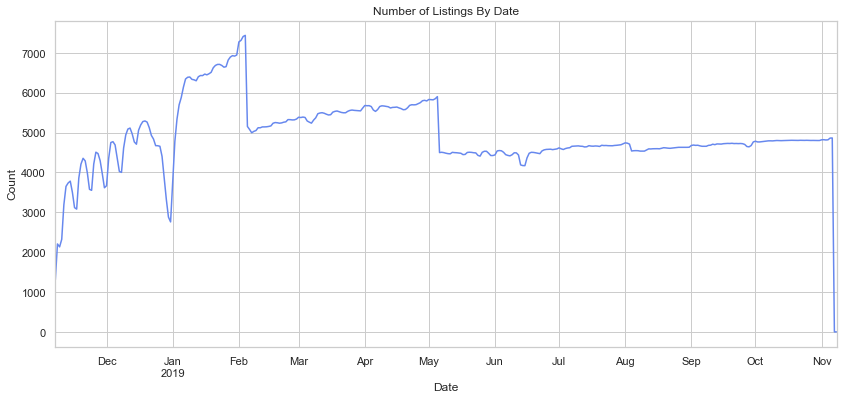

In [154]:
plt.figure(figsize=(14,6))
calendar.groupby('date').count()['Price ($)'].plot()
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Number of Listings By Date')

There is a fluctuation in number of listings, there could be fewer listings late 2018 because it's winter and there are less people on holiday during this time. I'm not sure what the reason for the other fluctuation is.

Text(0.5, 1.0, 'Mean Price of Listings By Weekday')

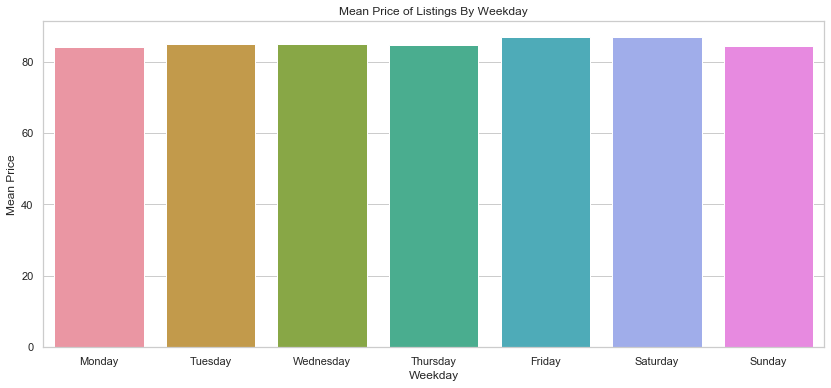

In [155]:
price_by_weekday = calendar.groupby('Weekday').mean()['Price ($)']
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plt.figure(figsize=(14,6))
sns.barplot(x=weekdays, y=price_by_weekday.values)
plt.xlabel('Weekday')
plt.ylabel('Mean Price')
plt.title('Mean Price of Listings By Weekday')

There is a very slight increase in mean price between Friday and Saturday and the rest of the week but not a huge amount.

Text(0.5, 1.0, 'Mean Price of Listings By Month')

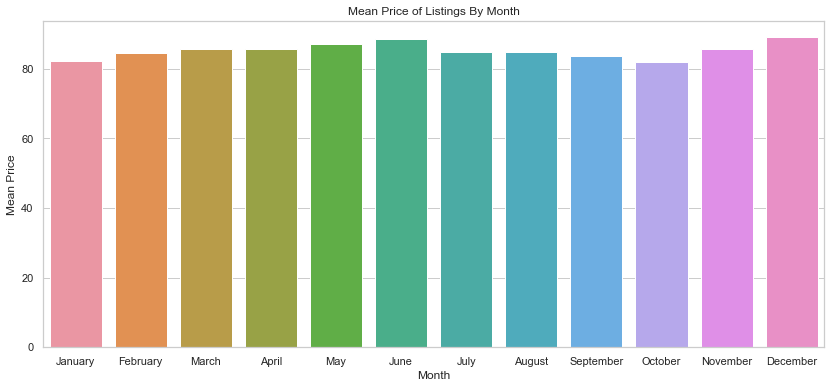

In [156]:
price_by_month = calendar.groupby('Month').mean()['Price ($)']
months = [
    'January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'September',
    'October',
    'November', 
    'December'
]
plt.figure(figsize=(14,6))
sns.barplot(x=months, y=price_by_month.values)
plt.xlabel('Month')
plt.ylabel('Mean Price')
plt.title('Mean Price of Listings By Month')

Again, there doesn't appear to be a huge amount of variation in mean price by month. Lets have a look at the variation in price by individual listing.

In [157]:
calendar.groupby('listing_id').std()['Price ($)'].describe()

count    11596.000000
mean         7.380854
std         29.228047
min          0.000000
25%          0.000000
50%          1.118034
75%          5.816608
max        933.869904
Name: Price ($), dtype: float64

There seems to be a small amount of variation in the majority of listings but there is a large amount of outliers and the standard deviations are heavily positively skewed.

### Summary

There doesn't seem to be a huge amount of variation in price based on the day of the week or month that the listing was available and it seems the a large proportion of listings don't vary the listings price based on date. It is unclear how I could use this data to help to predict the price of a listing and so I won't include it in my model. 

## Neighbourhoods

Analysing the neighbourhoods data.

In [158]:
neighbourhoods.describe()

,neighbourhood_group,neighbourhood
count,138,138
unique,12,138
top,Treptow - Köpenick,Schloßstr.
freq,20,1


In [159]:
neighbourhoods.head()

,neighbourhood_group,neighbourhood
0,Charlottenburg-Wilm.,Barstraße
1,Charlottenburg-Wilm.,Charlottenburg Nord
2,Charlottenburg-Wilm.,Düsseldorfer Straße
3,Charlottenburg-Wilm.,Forst Grunewald
4,Charlottenburg-Wilm.,Grunewald


So we have a dataframe that gives us information about the different neighbourhoods and the neighbourhood groups they belong to. Let's represent the number of neighbourhoods that constitute to a neighbourhood group using a barplot.

Text(0.5, 0, 'Neighbourhoods')

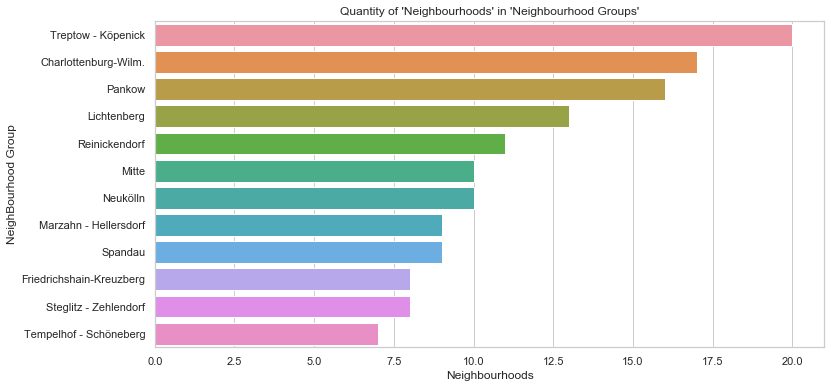

In [160]:
neighbourhood_groups_count = neighbourhoods["neighbourhood_group"].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(x=neighbourhood_groups_count.values, y=neighbourhood_groups_count.index)
plt.title("Quantity of 'Neighbourhoods' in 'Neighbourhood Groups'")
plt.ylabel("NeighBourhood Group")
plt.xlabel("Neighbourhoods")

## Listings

Now lets look at the listings and listings summary data.

In [161]:
listing_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22552 entries, 0 to 22551
Data columns (total 16 columns):
id                                22552 non-null int64
name                              22493 non-null object
host_id                           22552 non-null int64
host_name                         22526 non-null object
neighbourhood_group               22552 non-null object
neighbourhood                     22552 non-null object
latitude                          22552 non-null float64
longitude                         22552 non-null float64
room_type                         22552 non-null object
price                             22552 non-null int64
minimum_nights                    22552 non-null int64
number_of_reviews                 22552 non-null int64
last_review                       18644 non-null object
reviews_per_month                 18638 non-null float64
calculated_host_listings_count    22552 non-null int64
availability_365                  22552 non-null int64

More detailed listing information for Berlin

In [162]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22552 entries, 0 to 22551
Data columns (total 96 columns):
id                                  22552 non-null int64
listing_url                         22552 non-null object
scrape_id                           22552 non-null int64
last_scraped                        22552 non-null object
name                                22493 non-null object
summary                             21589 non-null object
space                               14020 non-null object
description                         22349 non-null object
experiences_offered                 22552 non-null object
neighborhood_overview               11540 non-null object
notes                               7215 non-null object
transit                             13036 non-null object
access                              10837 non-null object
interaction                         10406 non-null object
house_rules                         11449 non-null object
thumbnail_url           

Lets assess if the summary information gives any extra detail that the more detailed data misses.

In [163]:
set(listing_summary.columns) - set(listings.columns)

{'neighbourhood_group'}

There is a column, neighbourhood_group, in the summary information that is not in the detailed data but there is a column in the more detailed data called neighbourhood_group_cleansed that I suspect could be identical. 

In [164]:
all(listings['neighbourhood_group_cleansed'] == listing_summary['neighbourhood_group'])

True

As this was the same column we can change the name and check the data is the same in both dataframes.

In [165]:
listings['neighbourhood_group'] = listing_summary['neighbourhood_group']
listings.drop('neighbourhood_group_cleansed', axis=1, inplace=True)
all(listings[listing_summary.columns] == listing_summary)

True

Now we have confirmed all the information from the summary data in in the full listings data we can just work with the full dataframe. From the column names we can seperate our data into sections:

- Metadata 

('listing_url', 'scrape_id', 'last_scraped', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url').

This information won't be useful for our model.

- Host information

'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'calculated_host_listings_count'

All the information of the host of the listing, I don't think the majority of this will be useful but host_is_superhost could have an inpact on the price of a listing.

- Review Information

'number_of_reviews', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month'

This information wouldn't be relevant for a new customer.

- Information about availability

'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365'

This looks to be information about when the listing is available to book and wouldn't have any relationship with price.

All of these categories of data look to be non-informative and we can discount these from our model.

In [166]:
# List of keywords contained in non-informative columns
keywords = ['host', 'scrape', 'url', 'review', 'availability', 'calendar']
non_informative_cols = [
    {column for column in listings.columns if keyword in column}
    for keyword in keywords 
]
non_informative_cols = set().union(*non_informative_cols)
listings = listings.drop(non_informative_cols, axis=1)

Lets look at the different columns we still have to analyse.

In [167]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22552 entries, 0 to 22551
Data columns (total 52 columns):
id                                  22552 non-null int64
name                                22493 non-null object
summary                             21589 non-null object
space                               14020 non-null object
description                         22349 non-null object
experiences_offered                 22552 non-null object
neighborhood_overview               11540 non-null object
notes                               7215 non-null object
transit                             13036 non-null object
access                              10837 non-null object
interaction                         10406 non-null object
house_rules                         11449 non-null object
street                              22552 non-null object
neighbourhood                       21421 non-null object
neighbourhood_cleansed              22552 non-null object
city                   

The monthly/weekly price is strongly linked to what our model is meant to predict and so I won't use these as predictors. I also believe security deposit and cleaning fee could also be linked with price, i.e. a listing with a high price requires a high security deposit. Though these could have some kind of predictive nature with price as a lower cleaning price could mean a higher nightly price is needed. Maybe it would be a good idea to incorporate these together as a total price and use this as our target variable? I will discuss this further when I analyse these columns.

### Duplicates

In [168]:
all(~listings.duplicated())

True

There are no duplicates in our dataframe.

### Missing Values

Percentage of missing values in each column.

In [169]:
100 * (listings.isnull().sum()[(listings.isnull().sum() > 0)] / len(listings)).sort_values(ascending=False)

jurisdiction_names       100.000000
square_feet               98.022348
license                   92.736786
monthly_price             88.209471
weekly_price              83.677723
notes                     68.007272
interaction               53.857751
access                    51.946612
house_rules               49.232884
neighborhood_overview     48.829372
transit                   42.195814
security_deposit          41.508514
space                     37.832565
cleaning_fee              31.686768
neighbourhood              5.015076
summary                    4.270131
zipcode                    2.908833
description                0.900142
state                      0.372473
market                     0.279354
name                       0.261618
beds                       0.177368
bathrooms                  0.141894
bedrooms                   0.079816
city                       0.022171
dtype: float64

Any columns with large amounts of missing data are likely to be useless to us, with jurisdiction_names being entirely useless. It is a shame that the square feet column is mostly empty as I would of thought the size of the listing would be very important to the price of the property. We see that all of the columns that include prices are in the same form as above, we should convert these so we can analyse them.

In [170]:
currency_columns = [
    'price',
    'weekly_price',
    'monthly_price',
    'security_deposit',
    'cleaning_fee',
    'extra_people'
]
for currency_column in currency_columns:
    listings[currency_column + ' ($)'] = listings[currency_column].apply(price_to_float)

listings.drop(currency_columns, axis=1, inplace=True)

### Price

In [171]:
listings['price ($)'].describe()

count    22552.000000
mean        67.143668
std        220.266210
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price ($), dtype: float64

This data is very highly skewed and has a minimum of zero. It is strange to have listings with a price of zero, why have these properties been listed if they don't make any money? How many of these properties are there?

In [172]:
(listings['price ($)'] == 0).sum()

8

I won't include these listings in my model as the point of the model is to inform customers the price a property should be advertised for and zero is not a useful value. 

I will show the price distribution on a logarithmic scale so it is easier to visualise. As we have values that are zero, I will add 1 to every value.

Text(0.5, 1.0, 'Price Distribution')

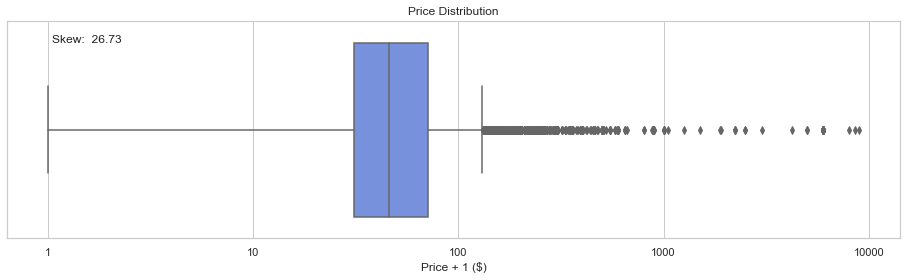

In [173]:
skew = listings['price ($)'].skew()
plt.figure(figsize=(16,4))
sns.boxplot(x=listings['price ($)']+1)
plt.xscale('log')
plt.xticks([1,10,100,1000,10000],[1,10,100,1000,10000])
plt.xlabel('Price + 1 ($)')
plt.text(1.05, -0.4, f'Skew: {skew: .2f}')
plt.title('Price Distribution')

The price data is very highly skewed with a large number of outliers. This will make predicting price a challenge if we include these outliers, I think it would be a good idea to limit the price calculator model to prices below a certain threshold. I will create a marker feature that will mark any listings with a price greater than the mean + 2 standard deviations. I will treat these as the outliers and using this marker I can look at relationships between features and the price using the entire data set and also just the non-outliers.

In [174]:
price_ulim = listings['price ($)'].mean() + 2*listings['price ($)'].std()
listings['Price Outlier'] = listings['price ($)'].apply(lambda x: np.where(x==0 or x>price_ulim, 1, 0))
listings_no_outliers = listings[listings['Price Outlier'] == 0]

How many outliers do we have?

In [175]:
listings['Price Outlier'].value_counts()

0    22472
1       80
Name: Price Outlier, dtype: int64

Now we can look at the distribution of price without including the outliers.

Text(0.5, 1.0, 'Price Distribution (Without Outliers)')

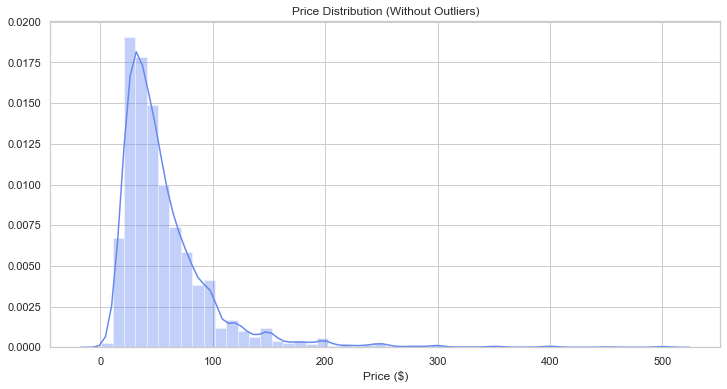

In [176]:
plt.figure(figsize=(12,6))
sns.distplot(listings_no_outliers['price ($)'])
plt.xlabel('Price ($)')
plt.title('Price Distribution (Without Outliers)')

The columns seem to have different categories:

- Location
- Property Details
- Add ons
- Other

Lets analyse these in this order.

### Location

Firstly, lets confirm all listings are in Berlin.

In [177]:
listings['country'].value_counts()

Germany    22552
Name: country, dtype: int64

In [178]:
listings['country_code'].value_counts()

DE    22552
Name: country_code, dtype: int64

So here we find the country and country code for all listings is Germany, DE. There is no variation in these columns and so will not be any use to our model.

In [179]:
listings['city'].value_counts()

Berlin                                22417
.                                        12
Berlin                                   12
Schöneberg                               11
Mitte                                     8
*                                         6
berlin                                    5
Berlin-Wilmersdorf                        3
Berlin, friedrichshain                    3
Friedrichshain                            3
Berlino                                   3
Berlin - Mitte                            3
Weissensee                                3
Kleinmachnow                              3
Berlin, Berlin, DE                        2
Potsdam                                   2
Berlin-Mitte                              2
Berlin-Schöneberg                         2
Berlin Mitte                              2
Berlin-Friedrichshain                     2
Βερολίνο                                  2
Berlin - Schöneberg                       2
Berlín                          

All of the different values in the city column are in Berlin or surround Berlin. We can visualise the locations of each listing by using geopandas.

In [180]:
places = gpd.read_file('../berlin_geomap/gis_osm_places_a_free_1.shp')
gdf = gpd.GeoDataFrame(listings, geometry=gpd.points_from_xy(listings['longitude'], listings['latitude']))

Text(0.5, 1, 'Listing Locations')

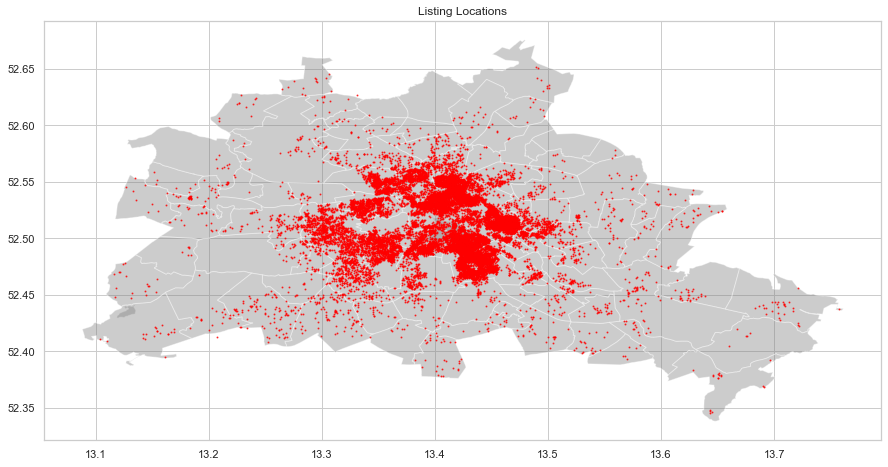

In [181]:
fig, ax = plt.subplots(figsize=(15,15))
places.plot(ax=ax, color='grey', alpha=0.4)
gdf.plot(ax=ax, alpha=0.7, markersize=1, color='red')
plt.title('Listing Locations')

The majority of the listings are located around the centre of Berlin, with fewer listings further from the centre. We can analyse the listings by neighbourhood.

#### Neighbourhood

We seem to have a few columns that contain information about the listings neighbourhood.

In [182]:
listings['neighbourhood'].nunique()

91

In [183]:
listings['neighbourhood'].describe()

count        21421
unique          91
top       Neukölln
freq          3209
Name: neighbourhood, dtype: object

This gives information about a neighbourhood the listing is in.

In [184]:
listings['neighbourhood_cleansed'].nunique()

136

In [185]:
listings['neighbourhood_cleansed'].describe()

count                    22552
unique                     136
top       Tempelhofer Vorstadt
freq                      1325
Name: neighbourhood_cleansed, dtype: object

We seem to have a column here with more precise information about the neighbourhood the listing is located.

In [186]:
listings['neighbourhood_group'].nunique()

12

Text(0.5, 1.0, 'Distribution by Neighbourhood Group')

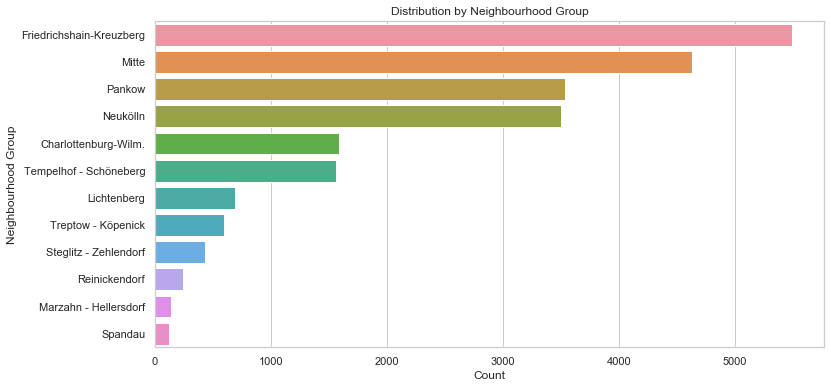

In [187]:
listings_by_neighbourhood = listings["neighbourhood_group"].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(x=listings_by_neighbourhood.values,y=listings_by_neighbourhood.index)
plt.xlabel("Count")
plt.ylabel("Neighbourhood Group")
plt.title("Distribution by Neighbourhood Group")

This column sperates the neighbourhood groups into 12 and so each neighbourhood refers to a much larger area and each neighbourhood group contains a much larger quantity of listings. There are a large number of listings in the most central neighbourhoods and less in further out neighbourhoods.

Text(0, 0.5, 'Neighbourhood Group')

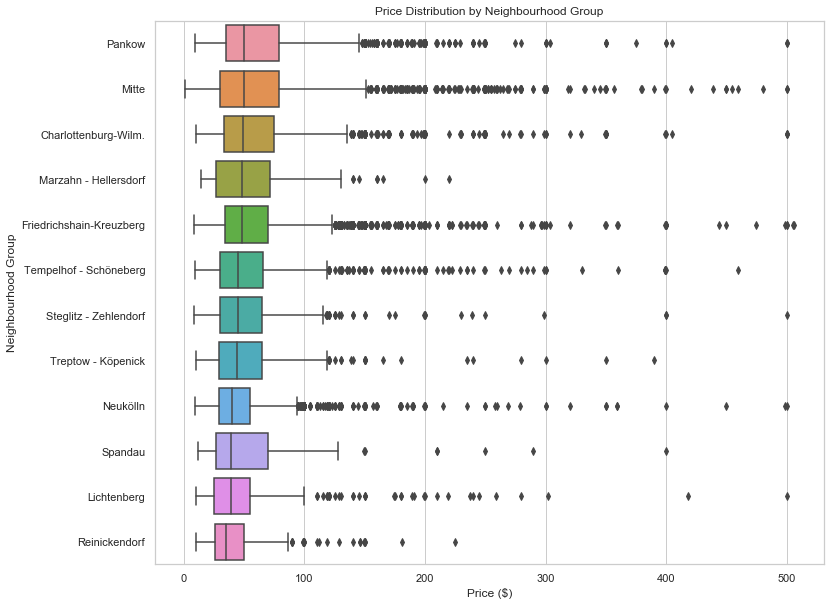

In [188]:
result = listings_no_outliers.groupby('neighbourhood_group').median()['price ($)'].sort_values(ascending=False).index
plt.figure(figsize=(12,10))
sns.boxplot(
    x=listings_no_outliers['price ($)'],
    y=listings_no_outliers['neighbourhood_group'], 
    order=result
)
plt.title('Price Distribution by Neighbourhood Group')
plt.xlabel('Price ($)')
plt.ylabel('Neighbourhood Group')

There seems to be some variation in price based on neighbourhood group, this could be a useful nominal variable for our model with listings in a more central neighbourhood group having a higher median price. Although, there is still a large amount of variation within each neighbourhood group. Using more exact neighbourhoods may help to reduce variation and identify neighbourhoods with different price ranges.

In [189]:
print(
    'Missing values in neighbourhood column: ',
    listings_no_outliers['neighbourhood'].isnull().sum()
)
print(
    'Missing values in neighbourhood_cleansed column: ',
    listings_no_outliers['neighbourhood_cleansed'].isnull().sum()
)

Missing values in neighbourhood column:  1128
Missing values in neighbourhood_cleansed column:  0


It seems our neighbourhood_cleansed column has no missing values, this may be more accurate information about the listing neighbourhood.

In [190]:
price_means = listings_no_outliers.groupby('neighbourhood_cleansed').mean()['price ($)']
counts = listings_no_outliers.groupby('neighbourhood_cleansed').count()['id']
result = pd.merge(counts, price_means, left_index=True, right_index=True)
result = result.rename(columns={'id':'count','price ($)':'mean'}).sort_values('mean', ascending=False)
result['count'][0]

3

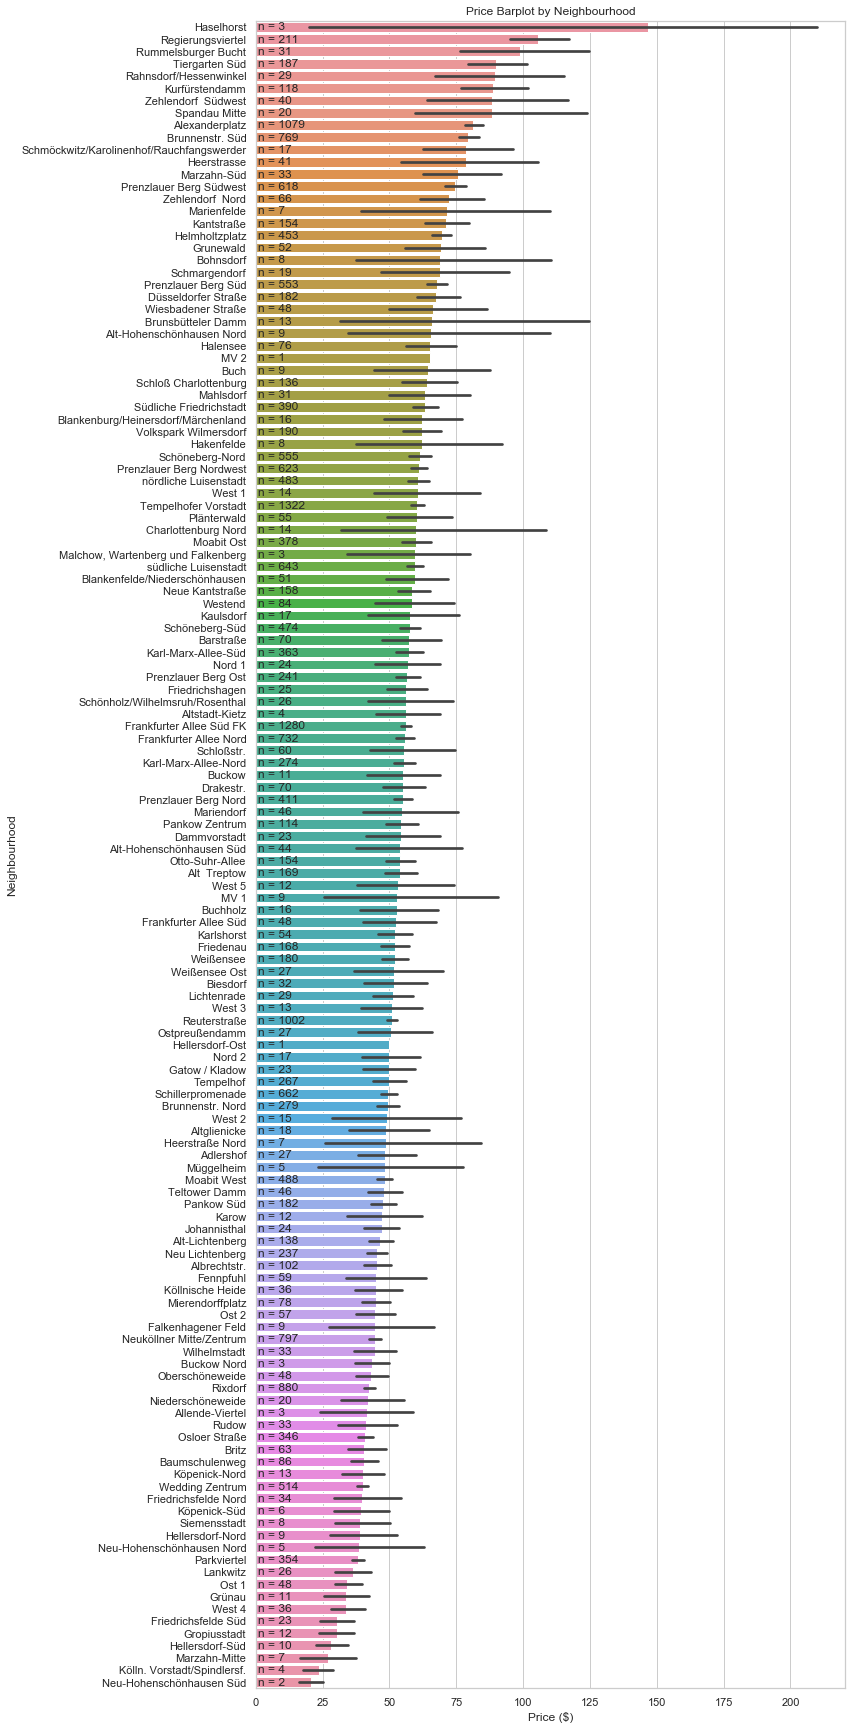

In [191]:
price_means = listings_no_outliers.groupby('neighbourhood_cleansed').mean()['price ($)']
counts = listings_no_outliers.groupby('neighbourhood_cleansed').count()['id']
result = pd.merge(counts, price_means, left_index=True, right_index=True)
result = result.rename(columns={'id':'count','price ($)':'mean'}).sort_values('mean', ascending=False)
plt.figure(figsize=(12,24))
chart = sns.barplot(
    y=listings_no_outliers['neighbourhood_cleansed'], 
    x=listings_no_outliers['price ($)'], 
    order=result.index
)
plt.tight_layout()
plt.title('Price Barplot by Neighbourhood')
plt.ylabel('Neighbourhood')
plt.xlabel('Price ($)')


for i, p in enumerate(chart.patches):
    y = p.get_bbox().get_points()[:,1]
    chart.annotate(f"n = {result['count'][i]}", (1, y.mean()), ha='left', va='center')

There seems to be some much more defined differences when seperated using the neighbourhood feature. This could be more useful to a machine learning model, although this would require us to have many more dummy columns.

In [192]:
listings['neighborhood_overview']

0        It is located in the former East Berlin area o...
1                                                      NaN
2        The neighbourhood is famous for its variety of...
3        My flat is in the middle of West-Berlin, direc...
4        Great neighborhood with plenty of Cafés, Baker...
                               ...                        
22547    The charming, stylish and cosmopolitan Berlin ...
22548                                                  NaN
22549                                                  NaN
22550    Within walking distance you can reach many pla...
22551    Neukölln entzückt mit seiner unnachahmlichen B...
Name: neighborhood_overview, Length: 22552, dtype: object

I am not sure at this stage what useful features I could extract from this text data. This is a description written by the host to sell the neighbourhood, therefore there is bound to be some exageration and not all descriptions will contain the same information. Though I will create an indicator variable for including a neighbourhood description in the listing as this could add some value.

In [193]:
has_neighbourhood_overview = listings_no_outliers['neighborhood_overview'].notnull().astype('int')
has_neighbourhood_overview.name = 'neighbourhood_overview_indicator'
listings_no_outliers = pd.concat([listings_no_outliers, has_neighbourhood_overview], axis=1)

Text(0, 0.5, 'Price ($)')

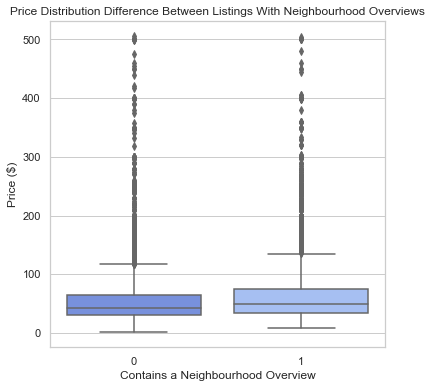

In [194]:
plt.figure(figsize=(6,6))
sns.boxplot(
    data=listings_no_outliers,
    y=listings_no_outliers['price ($)'],
    x=listings_no_outliers['neighbourhood_overview_indicator'],
)
plt.title('Price Distribution Difference Between Listings With Neighbourhood Overviews')
plt.xlabel('Contains a Neighbourhood Overview')
plt.ylabel('Price ($)')

There appears to be a slight difference in price depending on a if a listing contains a neighbourhood overview. Lets continue to analyse the rest of the columns concerned with location.

In [195]:
listings_no_outliers['state'].value_counts()

Berlin                    22339
Brandenburg                  14
Mitte                         5
Schleswig-Holstein            5
Germany                       5
berlin                        3
Deutschland                   3
Friedrichshain                2
NDS                           2
X                             1
Prenzlauerberg                1
Berlin, friedrichshain        1
DE                            1
Berlín                        1
neukoelln                     1
Zehlendorf                    1
BRD                           1
Berlino                       1
BY                            1
Name: state, dtype: int64

It seems this column won't offer much insight as there is little variation and most of the variation is mislabeling.

In [196]:
listings_no_outliers['zipcode'].describe()

count     21817
unique      215
top       10245
freq        853
Name: zipcode, dtype: object

There is too much variation in this column to be useful to our model.

In [197]:
listings_no_outliers['street'].describe()

count                       22472
unique                         86
top       Berlin, Berlin, Germany
freq                        22251
Name: street, dtype: object

In [198]:
listings_no_outliers['street'].value_counts()

Berlin, Berlin, Germany                           22251
Berlin, Germany                                      72
., Berlin, Germany                                   12
Mitte, Berlin, Germany                                8
Berlin , Berlin, Germany                              6
                                                  ...  
Gosen-Neu Zittau, Brandenburg, Germany                1
SavignyPlatz (Charlottenburg), Berlin, Germany        1
Wannsee, Berlin, Germany                              1
Berlin-Neukölln, Berlin, Germany                      1
10999 Berlin, Germany                                 1
Name: street, Length: 86, dtype: int64

Again we have another column with one category containing the majority of listings and the other categories having very few examples. This will be dropped from our model.

In [199]:
listings_no_outliers['market'].describe()

count      22409
unique         6
top       Berlin
freq       22403
Name: market, dtype: object

Again we have a column with very little variation, so will not be useful to the model.

In [200]:
listings_no_outliers['smart_location'].describe()

count               22472
unique                 61
top       Berlin, Germany
freq                22351
Name: smart_location, dtype: object

In [201]:
listings_no_outliers['smart_location'].value_counts()

Berlin, Germany                   22351
., Germany                           12
Berlin , Germany                     12
Mitte, Germany                        8
berlin, Germany                       5
                                  ...  
Berlin Friedrichshain, Germany        1
Берлин, Germany                       1
Wannsee, Germany                      1
Woltersdorf, Germany                  1
柏林, Germany                           1
Name: smart_location, Length: 61, dtype: int64

Here we have another column with very little variation and doesn't give us very much useful information for our model. This will need to be removed for our model.

In [202]:
listings_no_outliers['is_location_exact'].value_counts()

t    16726
f     5746
Name: is_location_exact, dtype: int64

Text(0, 0.5, 'Price ($)')

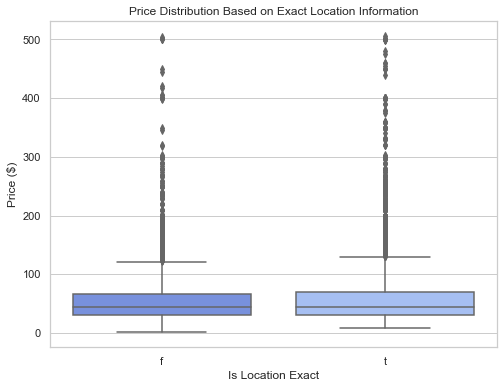

In [203]:
plt.figure(figsize=(8,6))
sns.boxplot(
    x=listings_no_outliers['is_location_exact'],
    y=listings_no_outliers['price ($)']
)
plt.title('Price Distribution Based on Exact Location Information')
plt.xlabel('Is Location Exact')
plt.ylabel('Price ($)')

There doesn't seem to be much difference between groups that have exact location information and those without, I don't think this will be important to our model but won't remove it for now.

### Property Details

#### Name

In [204]:
listings_no_outliers['name'].describe()

count              22414
unique             21796
top       Berlin Wohnung
freq                  14
Name: name, dtype: object

There is a large amount of variation in this column, so won't be useful for our model.

#### Summary

In [205]:
listings_no_outliers['summary'].describe()

count                                                 21535
unique                                                20992
top       with en-suite bathroom, TV, WIFI, bed linen, a...
freq                                                     14
Name: summary, dtype: object

In [206]:
listings_no_outliers['summary'].head(10)

0    Great location!  30 of 75 sq meters. This wood...
1                                                  NaN
2    This beautiful first floor apartment  is situa...
3    First of all: I prefer short-notice bookings. ...
4    Cozy and large room in the beautiful district ...
5    4 bedroom with very large windows and outstand...
6    The apartment is located on the upper second f...
7                                                  NaN
8    Light and sunny 2-Room-turn of the century-fla...
9    The 25 sqm room is located in the heart of Ber...
Name: summary, dtype: object

Of the listings that include a summary we have a short summary of the listing written by the host. I noticed that some of these summaries include the size of the room, which could be useful. If anything useful can be taken from this column then I will do this in feature engineering.

#### Space

In [207]:
listings_no_outliers['space'].describe()

count                                                 13957
unique                                                13550
top       The Singer 109 Hostel is located in the heart ...
freq                                                     41
Name: space, dtype: object

In [208]:
listings_no_outliers['space'].head(10)

0    A+++ location! This „Einliegerwohnung“ is an e...
1    In the summertime we are spending most of our ...
2    1st floor (68m2) apartment on Kollwitzplatz/ P...
3    Your room is really big and has 26 sqm, is ver...
4    The BrightRoom is an approx. 20 sqm (215ft²), ...
5    THE APPARTMENT - 4 bedroom (US, Germany: 5 roo...
6    The apartment is located on the south-facing s...
7    Hello future guests! We want to rent our cute ...
8    Rent in the heart of Berlin - Kreuzberg Newly ...
9    A 25 sqm room in the heart of Berlin. Many pla...
Name: space, dtype: object

This is another descriptive column, which again seems to include some information about size but has a larger quantity of missing values. I will investigate further during feature engineering.

#### Description

In [209]:
listings_no_outliers['description'].describe()

count                                                 22270
unique                                                21933
top       with en-suite bathroom, TV, WIFI, bed linen, a...
freq                                                     12
Name: description, dtype: object

In [210]:
listings_no_outliers['description'].head(10)

0    Great location!  30 of 75 sq meters. This wood...
1    In the summertime we are spending most of our ...
2    This beautiful first floor apartment  is situa...
3    First of all: I prefer short-notice bookings. ...
4    Cozy and large room in the beautiful district ...
5    4 bedroom with very large windows and outstand...
6    The apartment is located on the upper second f...
7    Hello future guests! We want to rent our cute ...
8    Light and sunny 2-Room-turn of the century-fla...
9    The 25 sqm room is located in the heart of Ber...
Name: description, dtype: object

Another similar column, some of the data looks to be identical to the previous two columns but this has fewer missing values to consider, maybe this is the most useful column for feature engineering.

#### Experiences Offered

In [211]:
listings_no_outliers['experiences_offered'].describe()

count     22472
unique        1
top        none
freq      22472
Name: experiences_offered, dtype: object

There is no variance in this column and so has no value to our model.

#### Notes

In [212]:
listings_no_outliers['notes'].describe()

count                                                  7188
unique                                                 6667
top       Since 01.01.2014 the city of Berlin had to ado...
freq                                                     37
Name: notes, dtype: object

In [213]:
listings_no_outliers['notes'].head()

0    This is my home, not a hotel. I rent out occas...
1                                                  NaN
2    We welcome FAMILIES and cater especially for y...
3    The flat is a strictly non-smoking facility! A...
4    I hope you enjoy your stay to the fullest! Ple...
Name: notes, dtype: object

This column has a large amount of missing data, however an indicator column could be of use or I may be able to gather information from the text. Will investigate further in feature engineering.

#### Transit

In [214]:
listings_no_outliers['transit'].describe()

count                                                 12999
unique                                                12281
top       U-Bahn / Underground /Subway / Metro: U5 (Stra...
freq                                                     26
Name: transit, dtype: object

In [215]:
listings_no_outliers['transit'].head()

0    Close to U-Bahn U8 and U2 (metro), Trams M12, ...
1    Within walking distance you'll find the S-Bahn...
2    We are 5 min walk  away from the tram M2, whic...
3    The public transportation is excellent: Severa...
4    Best access to other parts of the city via pub...
Name: transit, dtype: object

At the very least this could provide a indicator column for travel advice and I may be able to create new columns from this to indicate the different travel options to get to the listing.

#### Access

In [216]:
listings_no_outliers['access'].describe()

count                                                 10807
unique                                                 9921
top       We can offer our guests - Pool table/Snooker -...
freq                                                     42
Name: access, dtype: object

In [217]:
listings_no_outliers['access'].head()

0    Simple kitchen/cooking, refrigerator, microwav...
1    Außer deinem Zimmer kannst du noch die Küche u...
2    The apartment will be entirely yours. We are c...
3    I do have a strictly non-smoker-flat.  Keep th...
4    The guests have access to the bathroom, a smal...
Name: access, dtype: object

Similar to other columns. Doesn't seem to provide much information about accessibility for most cases.

#### Property Type

In [218]:
listings_no_outliers["property_type"].nunique()

33

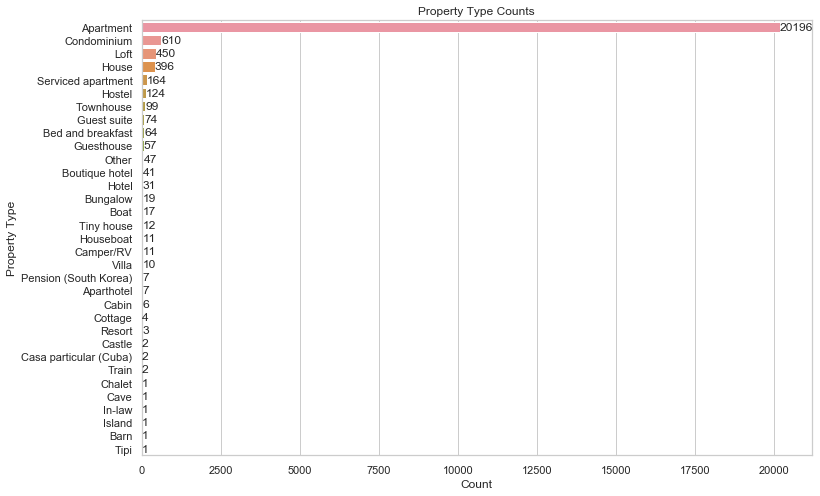

In [219]:
result = listings_no_outliers.groupby("property_type").count()["id"].sort_values(ascending=False)
plt.figure(figsize=(12,8))
ax = sns.countplot(y=listings_no_outliers['property_type'], order=result.index)
plt.title('Property Type Counts')
plt.xlabel('Count')
plt.ylabel('Property Type')
for p in ax.patches:
    x = p.get_bbox().get_points()[1, 0]
    y = p.get_bbox().get_points()[:,1]
    ax.annotate(f'{int(x)}', (x, y.mean()), ha='left', va='center')

There are a lot of property types with very few listings, I will combine related property types in a sensible manor.

Thoughts:

- Combine House, Cottage, Villa, Bungalow, Townhouse and Guesthouse as House.
- Combine Aparthotel, Hotel and Boutique Hotel as Hotel.
- Anything less than 50 occurances combine with other.

Text(0, 0.5, 'Price ($)')

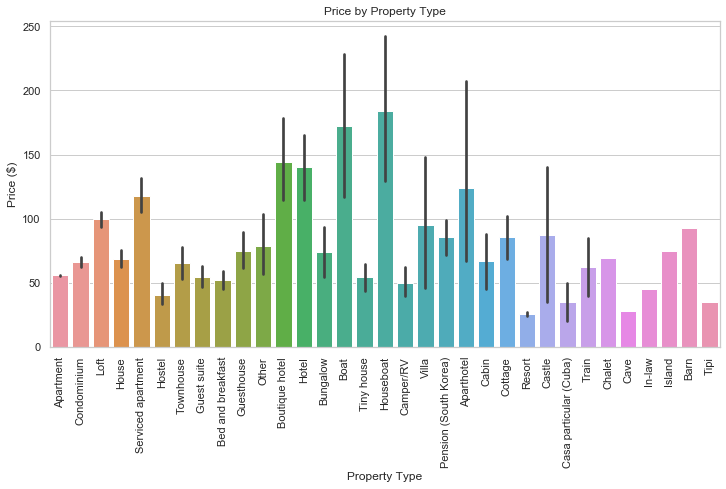

In [220]:
plt.figure(figsize=(12,6))
chart = sns.barplot(
    x=listings_no_outliers['property_type'],
    y=listings_no_outliers['price ($)'],
    order=result.index
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.title('Price by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Price ($)')

The property type provides a lot of variation in price, this could be due to the small numbers in some categories too. Combining diffrent categories will provide more confidence in the variance.

#### Room Type

In [221]:
listings_no_outliers['room_type'].value_counts()

Private room       11497
Entire home/apt    10681
Shared room          294
Name: room_type, dtype: int64

Text(0.5, 1.0, 'Distribution by Room Type')

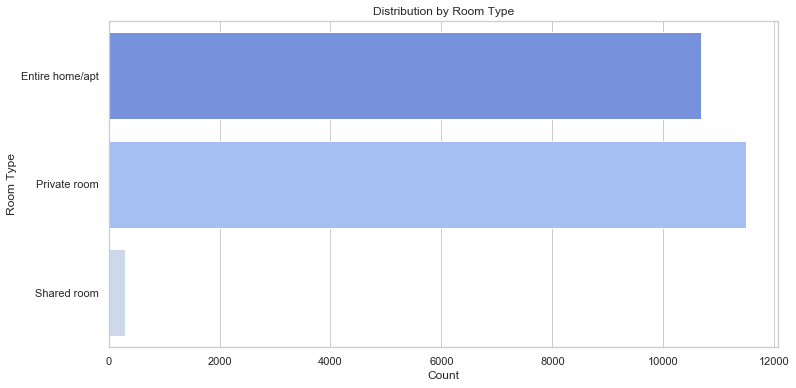

In [222]:
plt.figure(figsize=(12,6))
sns.countplot(y=listings_no_outliers['room_type'])
plt.xlabel("Count")
plt.ylabel("Room Type")
plt.title("Distribution by Room Type")

We have three different room types with the majority of listings being entire homes or private rooms.

Text(0, 0.5, 'Price ($)')

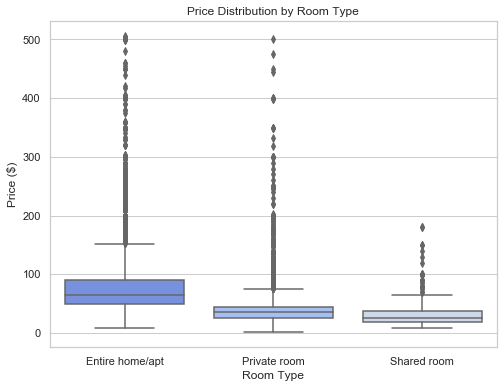

In [223]:
plt.figure(figsize=(8,6))
sns.boxplot(x=listings_no_outliers['room_type'], y=listings_no_outliers['price ($)'])
plt.title('Price Distribution by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price ($)')

There seems to be some variation in distribution of price based on the room type. It seems entire homes have a higher median price and a larger interquartile range compared to the other room types. There are also no shared rooms with a price more than $200, whereas the other room types have many listings with higher prices.

#### Bed Type

In [224]:
listings_no_outliers["bed_type"].value_counts()

Real Bed         21689
Pull-out Sofa      449
Futon              240
Couch               71
Airbed              23
Name: bed_type, dtype: int64

It seems a good idea to combine all the other bed types other than real bed as they are similar types.

#### Square Feet

In [225]:
listings_no_outliers['square_feet'].isnull().sum()

22026

There is a large number of missing values for the square feet of the listing. I will try to fill this using the descriptive data in the other columns but otherwise I will have to remove this column.

#### Bedrooms

In [226]:
listings_no_outliers['bedrooms'].isnull().sum()

18

We have a small amount of missing values that can be filled in from other columns or using the mode.

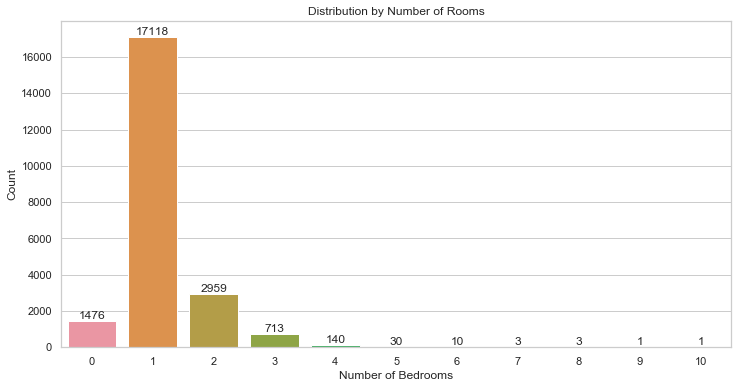

In [227]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x=listings_no_outliers['bedrooms'])
plt.title("Distribution by Number of Rooms")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Count")
ax.set_xticklabels([int(x) for x in ax.get_xticks()])

for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

The majority of our listings have between 0 and 2 bedrooms with most having only 1. What is the effect of number of bedrooms on price.

Text(0, 0.5, 'Price ($)')

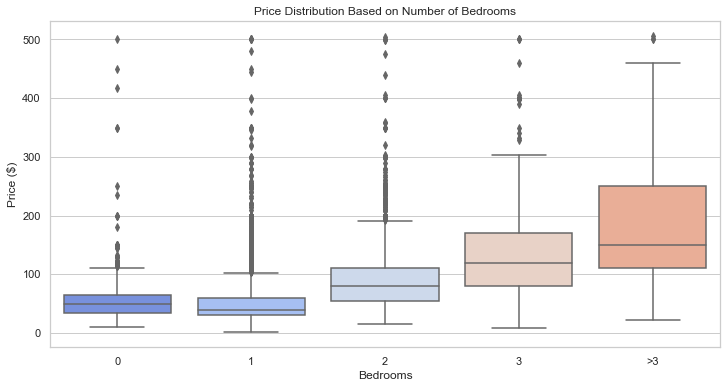

In [228]:
bedrooms_combined = listings_no_outliers['bedrooms'].dropna().apply(lambda x: '>3' if x>3 else str(int(x)))
order = ['0', '1', '2', '3', '>3']
plt.figure(figsize=(12,6))
sns.boxplot(x=bedrooms_combined, y=listings_no_outliers['price ($)'], order=order)
plt.title('Price Distribution Based on Number of Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Price ($)')

Clearly there is a difference in price distribution when the number of bedrooms is different. There seems to be little difference between 0 and 1 bedrooms but more than 1 the price median increases with every added bedroom.

#### Accomodates

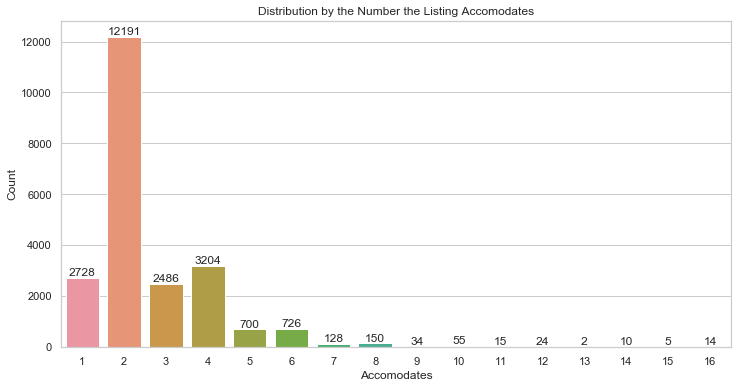

In [229]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x=listings_no_outliers['accommodates'])
plt.title('Distribution by the Number the Listing Accomodates')
plt.xlabel('Accomodates')
plt.ylabel('Count')

for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

I expect accomodates to be strongly associated with bedrooms, i.e. 1 bedroom accomodates 2 people. Though this feature may provide more detailed information to accomodates. Let's have a look at the association with price.

Text(0, 0.5, 'Price ($)')

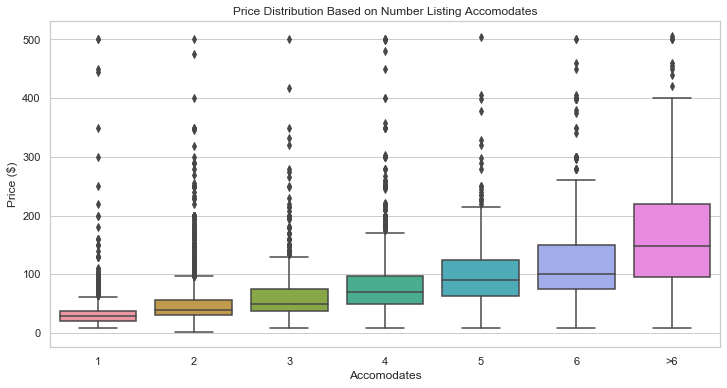

In [230]:
accomodates_combined = listings_no_outliers['accommodates'].apply(lambda x: '>6' if x>6 else str(x))
order = ['1', '2', '3', '4', '5', '6', '>6']
plt.figure(figsize=(12,6))
sns.boxplot(x=accomodates_combined, y=listings_no_outliers['price ($)'], order=order)
plt.title('Price Distribution Based on Number Listing Accomodates')
plt.xlabel('Accomodates')
plt.ylabel('Price ($)')

Again we see the median price increases as accomodates increases, indicating a strong link.

In [231]:
bedrooms_accomodates_corr = listings_no_outliers[['accommodates', 'bedrooms']].corr().iloc[0,1]
print(f'Bedrooms and Accomodates Correlation: {bedrooms_accomodates_corr: .2f}')

Bedrooms and Accomodates Correlation:  0.63


The correlation isn't as high as I thought it would be, it might be useful to include both features.

#### Beds

In [232]:
listings_no_outliers['beds'].isnull().sum()

38

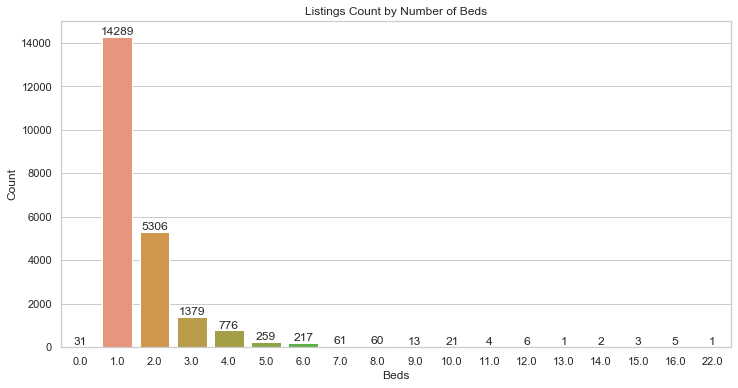

In [233]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x=listings_no_outliers['beds'])
plt.title('Listings Count by Number of Beds')
plt.xlabel('Beds')
plt.ylabel('Count')

for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

There seems to be a large variation on the number of beds. Also it is strange there is one listing with 22 beds but the most any of the listings accomodates is 16. I may not include this column in my model as there is already a large amount of information from accomodates and bedrooms about sleeping arrangements.

#### Bathrooms

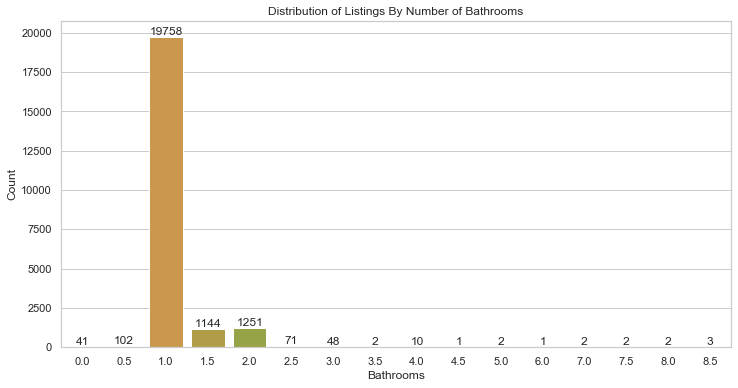

In [234]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x=listings_no_outliers['bathrooms'])
plt.title('Distribution of Listings By Number of Bathrooms')
plt.xlabel('Bathrooms')
plt.ylabel('Count')

for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

This feature doesn't have a huge amount of variation with the vast majority of listings having one bathroom. Let's see if there is any variation in price depending on number of bathrooms, we will combine all <1 and all >2.

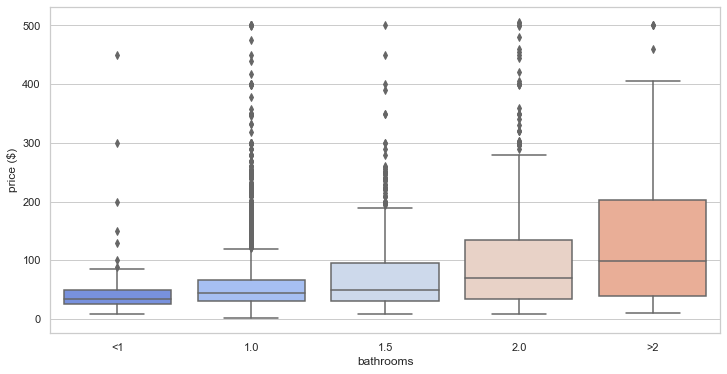

In [235]:
bathrooms_price = listings_no_outliers[['bathrooms', 'price ($)']].dropna()
bathrooms_price['bathrooms'] = bathrooms_price['bathrooms'].apply(
    lambda x: '<1' if x<1 else ('>2' if x>2 else str(x))
)
order = ['<1', '1.0', '1.5', '2.0', '>2']
plt.figure(figsize=(12,6))
sns.boxplot(x=bathrooms_price['bathrooms'], y=bathrooms_price['price ($)'], order=order)

There is some variation in price based on the number of bathrooms the listing has. This is likely because the number of bathrooms would be a good indicator to the size of the listing and I would predict the larger the listing, the more expensive it would be.

#### Amenities

In [236]:
listings_no_outliers['amenities'].head()

0    {TV,"Cable TV",Wifi,Kitchen,Gym,Heating,"Famil...
1    {Wifi,Kitchen,Elevator,Heating,Washer,Essentia...
2    {Internet,Wifi,Kitchen,"Buzzer/wireless interc...
3    {Internet,Wifi,"Pets allowed","Pets live on th...
4    {Wifi,Heating,"Family/kid friendly",Essentials...
Name: amenities, dtype: object

In [237]:
listings_no_outliers['amenities'][0]

'{TV,"Cable TV",Wifi,Kitchen,Gym,Heating,"Family/kid friendly","Smoke detector",Essentials,Shampoo,"Lock on bedroom door",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Private living room",Bathtub,"Hot water","Bed linens","Extra pillows and blankets",Microwave,"Coffee maker",Refrigerator,Dishwasher,"Dishes and silverware","Cooking basics",Stove,"Luggage dropoff allowed","Long term stays allowed"}'

The amenities feature looks to be a string containing curly brakets with different amenities seperated by commas. We will want to store this as a list instead. So we should remove the curly braces and quote marks and split the string at the commas. We will use regular expressions to remove the unwanted characters, split the data by commas to a list and take the set of that list to ensure there are no duplicates.

In [238]:
listings_no_outliers['amenities'] = listings_no_outliers['amenities'].apply(
    lambda x: set(re.sub('[{}"]', '', x).split(','))
)

Now we will create a counter object from each entry to find a list of all the different amenities and the occurances of each amenity.

In [239]:
amenity_counter = Counter()
listings_no_outliers['amenities'].apply(lambda x: amenity_counter.update(x))
len(amenity_counter)

136

We have 136 different amenities, let's look at how common each amenity is.

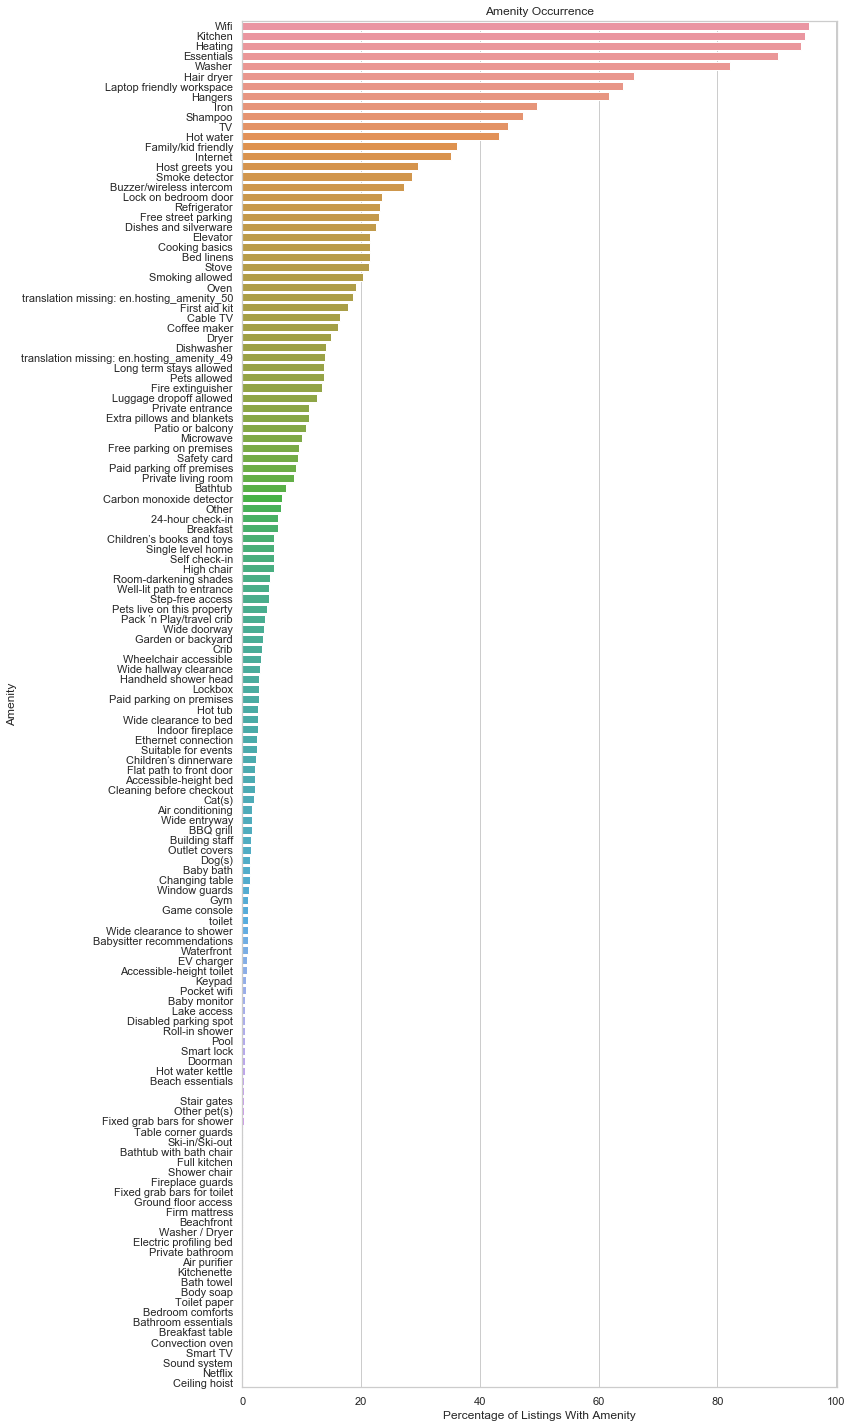

In [240]:
amenities_occurrences = pd.DataFrame(
    [amenity_counter.keys(),amenity_counter.values()],
    index=['Amenity', 'Occurrences']
).T
amenities_occurrences['Percentage Occurrences'] = 100*amenities_occurrences['Occurrences']/len(listings_no_outliers)
amenities_occurrences = amenities_occurrences.sort_values('Occurrences', ascending=False)
plt.figure(figsize=(12,20))
sns.barplot(x=amenities_occurrences['Percentage Occurrences'], y=amenities_occurrences['Amenity'])
plt.title('Amenity Occurrence')
plt.xlabel('Percentage of Listings With Amenity')
plt.tight_layout()

Uncommon and highly common amenities won't be particularly useful to our model. It would be best to include the amenities with a variance higher than a chosen threshold to maximise the importance to our model.

### Add Ons

#### Guests Included

In [241]:
listings_no_outliers['guests_included'].value_counts().sort_index()

1     17425
2      3951
3       374
4       520
5        60
6        86
7         7
8        24
9         4
10        7
11        1
12        5
13        1
14        2
16        5
Name: guests_included, dtype: int64

Text(0, 0.5, 'Price ($)')

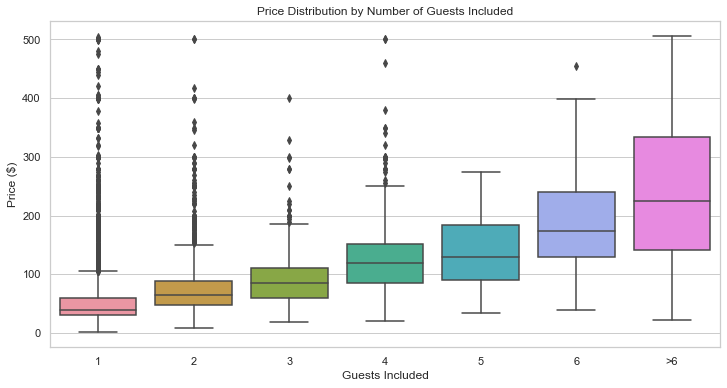

In [242]:
guests_included_combined = listings_no_outliers['guests_included'].apply(lambda x: '>6' if x>6 else x)
order = [1,2,3,4,5,6,'>6']
plt.figure(figsize=(12,6))
sns.boxplot(x=guests_included_combined, y=listings_no_outliers['price ($)'],order=order)
plt.title('Price Distribution by Number of Guests Included')
plt.xlabel('Guests Included')
plt.ylabel('Price ($)')

There looks to be a correlation between the number of guests included and the median price, this could therefore be a good predictor for price. Though this could be again an indicator of the size of the listing.

#### Mininmum Nights

In [243]:
listings_no_outliers['minimum_nights'].describe()

count    22472.000000
mean         7.170256
std         40.731092
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max       5000.000000
Name: minimum_nights, dtype: float64

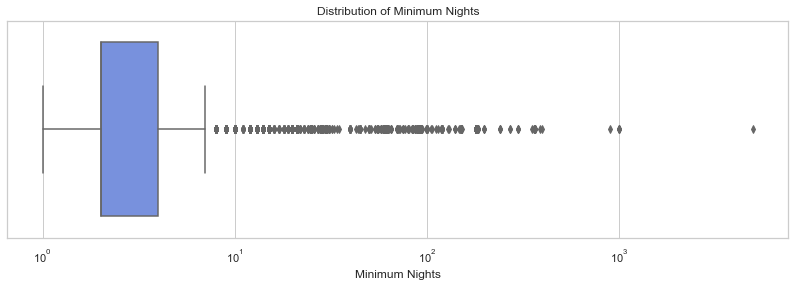

In [244]:
plt.figure(figsize=(14,4))
sns.boxplot(x=listings_no_outliers['minimum_nights'])
plt.title('Distribution of Minimum Nights')
plt.xlabel('Minimum Nights')
plt.xscale('log')

Strangely there are listings where the minimum stay is over one month. One listing has a minimum stay of over 13 years. I want to know if there is any difference between listings with minimum nights over 14 days and those under. 

In [245]:
(listings_no_outliers['minimum_nights']>28).sum()

1102

There is over 1000 listings with a minimum stay of over 4 weeks, could it be a good idea to drop these listings as these are no longer listings for travel/holidays and these could be classified as listings to rent long term? We are interested in predicting the price per night and these listings could be different in some way but I don't want to unecessarily drop that much information for my model to train on if the information is no different other than the minimum stay. I will leave it for now but might come back to this problem.

#### Maximum Nights

In [246]:
listings_no_outliers['maximum_nights'].describe()

count    2.247200e+04
mean     1.034144e+05
std      9.657663e+06
min      1.000000e+00
25%      2.000000e+01
50%      1.124000e+03
75%      1.125000e+03
max      1.000000e+09
Name: maximum_nights, dtype: float64

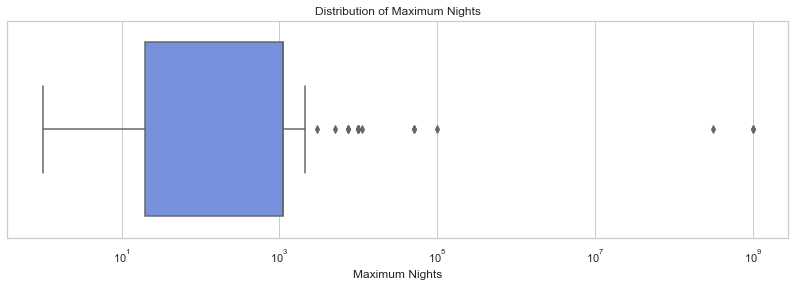

In [247]:
plt.figure(figsize=(14,4))
sns.boxplot(x=listings_no_outliers['maximum_nights'])
plt.title('Distribution of Maximum Nights')
plt.xlabel('Maximum Nights')
plt.xscale('log')

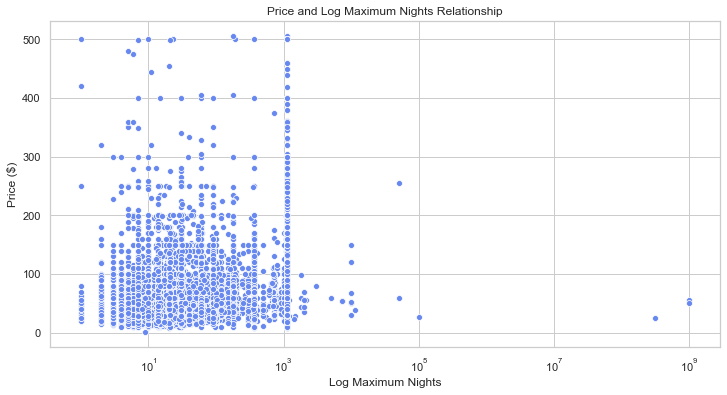

In [248]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    x=listings_no_outliers['maximum_nights'],
    y=listings_no_outliers['price ($)']
)
plt.title('Price and Log Maximum Nights Relationship')
plt.xlabel('Log Maximum Nights')
plt.ylabel('Price ($)')
plt.xscale('log')

There doesn't appear to be any correlation between log maximum nights and price and I don't believe maximum nights to have a causation with price, so won't use this in my model.

#### Instant Bookable

In [249]:
listings_no_outliers['instant_bookable'].value_counts()

f    15478
t     6994
Name: instant_bookable, dtype: int64

[Text(0, 0, 'False'), Text(0, 0, 'True')]

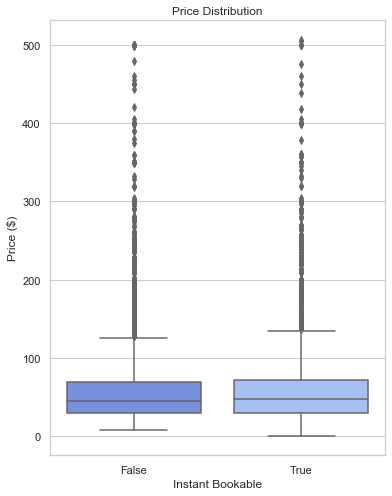

In [250]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(
    x=listings_no_outliers['instant_bookable'],
    y=listings_no_outliers['price ($)']
)
plt.title('Price Distribution')
plt.ylabel('Price ($)')
plt.xlabel('Instant Bookable')
ax.set_xticklabels(['False', 'True'])

There seems to be no significant difference in price distribution between listings that are instant bookable and those that aren't. 

#### Business Travel Ready

In [251]:
listings_no_outliers['is_business_travel_ready'].value_counts()

f    22472
Name: is_business_travel_ready, dtype: int64

There is no variation in this feature and so this won't be useful to our model and can be dropped.

#### Security Deposit

As the security deposit is related to the price of the listing I am not going to use it as a predictor, although it might be a good idea to create a total price. I'm not sure this makes sense though as the deposit will be refundable.

In [252]:
listings_no_outliers['security_deposit ($)'].describe()

count    13137.000000
mean       201.408997
std        373.907846
min          0.000000
25%          0.000000
50%        100.000000
75%        250.000000
max       4280.000000
Name: security_deposit ($), dtype: float64

Text(1.05, -0.42, 'Skew:  5.22')

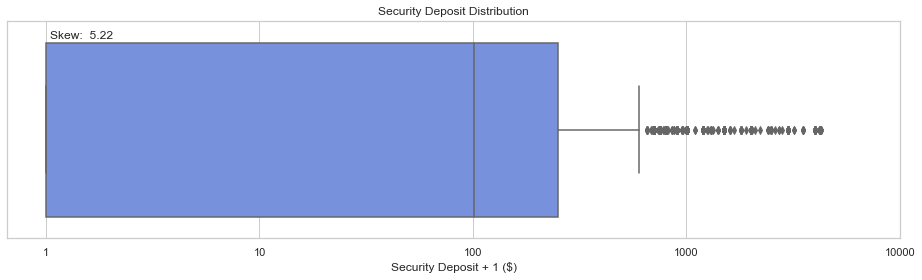

In [253]:
skew = listings_no_outliers['security_deposit ($)'].skew()
plt.figure(figsize=(16,4))
sns.boxplot(x=listings_no_outliers['security_deposit ($)']+1)
plt.xscale('log')
plt.xticks([1,10,100,1000,10000],[1,10,100,1000,10000])
plt.xlabel('Security Deposit + 1 ($)')
plt.title('Security Deposit Distribution')
plt.text(1.05, -0.42, f'Skew: {skew: .2f}')

I think I will ignore this as a column as I think there is too much variation to include in the predictor.

#### Cleaning Fee

Cleaning fee is another possible feature that could be combined with the price to produce a total price target variable. There are a lot of missing results, we need to think of why these are missing and how we can fill them.

Text(0.5, 0, 'Cleaning Fee ($)')

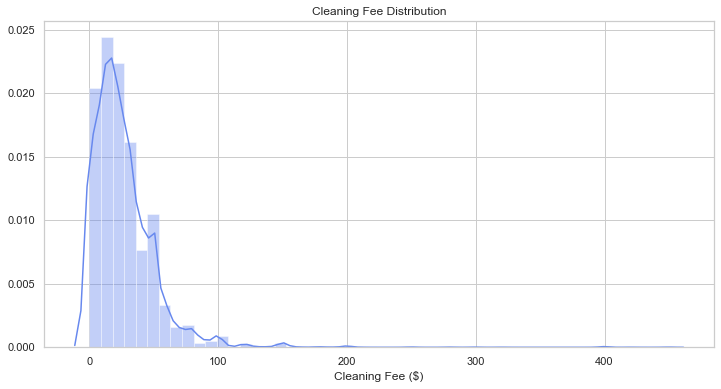

In [254]:
plt.figure(figsize=(12,6))
sns.distplot(listings_no_outliers['cleaning_fee ($)'])
plt.title('Cleaning Fee Distribution')
plt.xlabel('Cleaning Fee ($)')

Lets see if there is any difference in price between those with a cleaning fee and those missing the value.

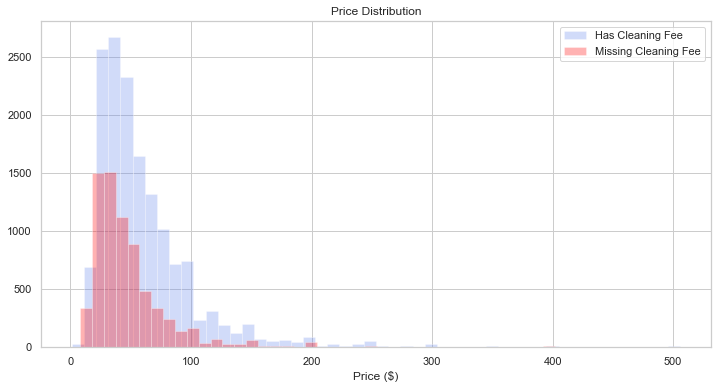

In [255]:
plt.figure(figsize=(12,6))
sns.distplot(
    listings_no_outliers[listings_no_outliers['cleaning_fee ($)'].notnull()]['price ($)'],
    kde=False,
    hist_kws={'alpha':0.3},
    label='Has Cleaning Fee'
)
sns.distplot(
    listings_no_outliers[listings_no_outliers['cleaning_fee ($)'].isnull()]['price ($)'],
    color='red',
    kde=False,
    hist_kws={'alpha':0.3},
    label='Missing Cleaning Fee'
)
plt.title('Price Distribution')
plt.xlabel('Price ($)')
plt.legend()

It seems the listings that have a cleaning fee seem to be slightly more expensive than the listings that are missing a cleaning fee value. Perhaps this could be because the listings that have a cleaning fee are generally nicer and so are more expensive. I will fill any missing values with 0.

#### Extra People

In [256]:
listings_no_outliers['extra_people ($)'].describe()

count    22472.000000
mean         8.263172
std         11.126164
min          0.000000
25%          0.000000
50%          5.000000
75%         15.000000
max        250.000000
Name: extra_people ($), dtype: float64

Text(0.5, 0, 'Extra People Fee ($)')

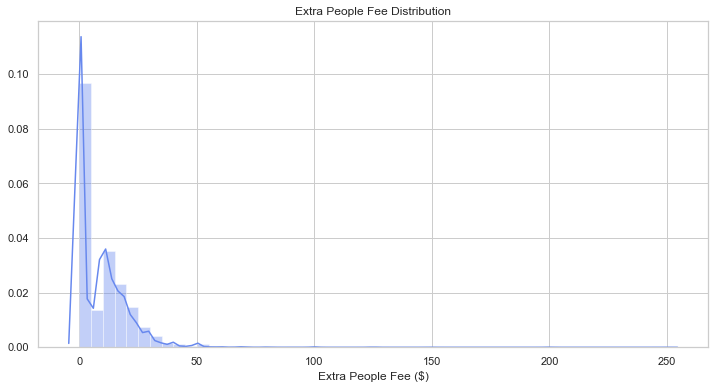

In [257]:
plt.figure(figsize=(12,6))
sns.distplot(listings_no_outliers['extra_people ($)'])
plt.title('Extra People Fee Distribution')
plt.xlabel('Extra People Fee ($)')

Text(0, 0.5, 'Price ($)')

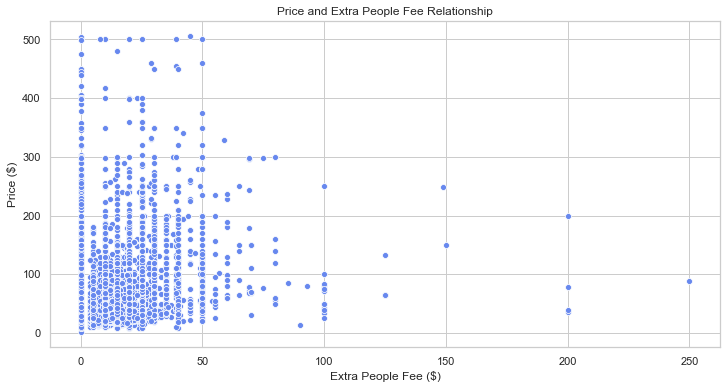

In [258]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    x=listings_no_outliers['extra_people ($)'],
    y=listings_no_outliers['price ($)'],
)
plt.title('Price and Extra People Fee Relationship')
plt.xlabel('Extra People Fee ($)')
plt.ylabel('Price ($)')

This is another feature that I'm not sure if it can be treated as a predictor and also I don't believe it can be combined with the target variable as not everyone would need to pay for extra people. I will decide when I'm modelling if I will include it as a predictor.

#### Cancellation Policy

In [259]:
listings_no_outliers['cancellation_policy'].value_counts()

flexible                       9063
moderate                       7079
strict_14_with_grace_period    6265
super_strict_30                  53
super_strict_60                  12
Name: cancellation_policy, dtype: int64

Text(0, 0.5, 'Price ($)')

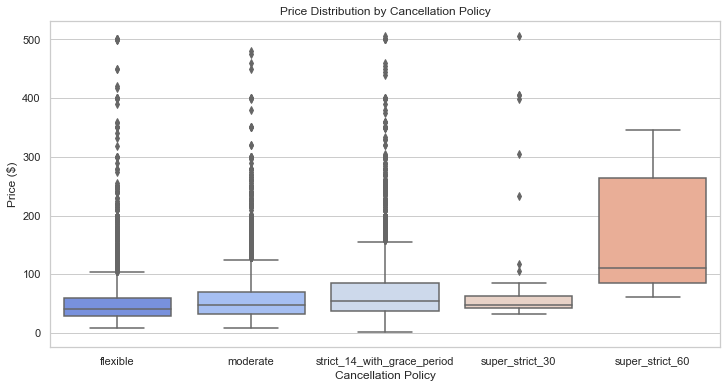

In [260]:
plt.figure(figsize=(12,6))
order = ['flexible', 'moderate', 'strict_14_with_grace_period', 'super_strict_30', 'super_strict_60']
sns.boxplot(
    x=listings_no_outliers['cancellation_policy'],
    y=listings_no_outliers['price ($)'],
    order=order
)
plt.title('Price Distribution by Cancellation Policy')
plt.xlabel('Cancellation Policy')
plt.ylabel('Price ($)')

We have five different cancellation policies with varying degrees of strictness. It doesn't appear that there is a significant difference in the distribution of price.

### Other

#### Interaction

In [261]:
listings_no_outliers['interaction'].head()

0                                     Always available
1                                                  NaN
2    Feel free to ask any questions prior to bookin...
3    I'm working as a freelancing photographer. My ...
4    I am glad if I can give you advice or help as ...
Name: interaction, dtype: object

This is a string with a lot of variance, I may be able to gain some features from this but I'm not sure what.

In [262]:
listings_no_outliers['interaction'].isnull().sum()

12121

Around half of the listings don't have any information for interaction, maybe an indicator variable would provide some information.

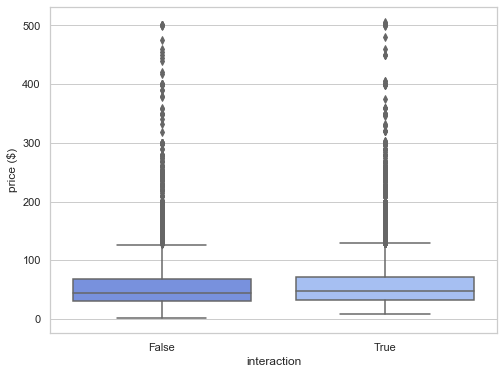

In [263]:
plt.figure(figsize=(8,6))
sns.boxplot(
    x=listings_no_outliers['interaction'].notnull(),
    y=listings_no_outliers['price ($)']
)

There doesn't seem to be a significant difference in price distribution between listings with interaction information and those without.

#### License

In [264]:
listings_no_outliers['requires_license'].value_counts()

t    22464
f        8
Name: requires_license, dtype: int64

There is almost no variation in this column and so will have very little value to a model.

In [265]:
100 * listings_no_outliers['license'].isnull().sum() / len(listings_no_outliers)

92.83107867568529

In [266]:
listings_no_outliers[listings_no_outliers['license'].notnull()]['license']

5                                        03/Z/RA/003410-18
11       Genehmigung BA Pankow 03/Z/ZA/002715-17 Genehi...
14                                       01/Z/NA/004976-16
18                       BD Wohn C 6 - 03/z/za/002795 - 17
20                                             13387408279
                               ...                        
22411                                         HR B 166587B
22426                                    02/Z/AZ/009014-18
22479                                    02/Z/AZ/008691-18
22499               02/Z/ZA/004738-17 Mindestaufenthalt 60
22530                                    08/Z/RA/006663-18
Name: license, Length: 1611, dtype: object

There is a very large amount of missing data from this column and any information is just a license number, which doesn't to be particularly helpful.

#### Requires Guest Information

In [267]:
listings_no_outliers['require_guest_profile_picture'].value_counts()

f    22316
t      156
Name: require_guest_profile_picture, dtype: int64

In [268]:
listings_no_outliers['require_guest_phone_verification'].value_counts()

f    22193
t      279
Name: require_guest_phone_verification, dtype: int64

These columns have very little variation and so won't be very helpful for our model and so can be dropped.

#### House Rules

In [269]:
listings_no_outliers['house_rules'].head()

0    No parties No events No pets No smoking, not e...
1                                                  NaN
2    It’s a non smoking flat, which likes to be tre...
3    House-Rules and Information ..............(deu...
4    Please take good care of everything during you...
Name: house_rules, dtype: object

In [270]:
listings_no_outliers['house_rules'].notnull().sum()

11395

This is another string with a lot of variation. Some of these talk about non smoking, perhaps that can be used to create a dummy column. Otherwise we can look at an indicator variable to signify that the listing has house rules.

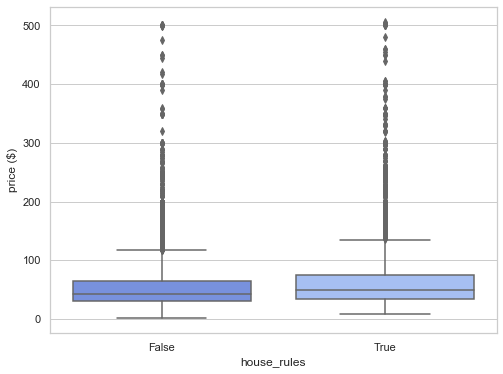

In [271]:
plt.figure(figsize=(8,6))
sns.boxplot(
    x=listings_no_outliers['house_rules'].notnull(),
    y=listings_no_outliers['price ($)']
)

There is little evidence that including house rules makes the listing more expensive.

## Exploration Review

1. Calendar Summary

    - The only missing values are in the price column.
    - Price is only missing when available is 'f'.
    - The entries are from the period of 7/11/2018 to 8/11/2019
    - Could this be used to analyse how prices/availability fluctuate depending on time of year/day of the week?
  
  
2. Neighbourhoods

    - There are 12 neighbourhood groups that contain 138 neighbourhoods in total.
 

3. Listings

    - The price column, the target, is very heavily skewed with a large amount of outliers. This may make it hard to have an accurate model if all the data is used, hence I have decided to remove any values greater than two standard deviations from the mean and also listings with a price of zero.
    - There are five columns with entirely empty columns and many missing the majority of entries.
    - There are many columns that a host wouldn't have the information for the listing and many features are entirely non-informative for predicting the price, these will be removed from our modelling during cleaning.
    - A large amount of the properties are located around the centre of Berlin.
    - There are a small amount of rows missing (seemingly) important information (beds, etc.), that can be filled during cleaning.
    - There are six columns with descriptive text data about the listing, these could be used to extract important quantative data about the listings to use in the model.